In [1]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
import json
import pandas as pd
import seaborn as sns

### Check Overfitting

In [2]:
val = pd.read_csv("../results/validation_results.csv", sep=";")
val["Model"] = val["Model"].str.replace("val_", "")
val["Data"] = "train"
val_rmse = val[["Model", "Data", "RMSE"]]
val_ps = val[["Model", "Data", "PredictiveScore"]]

test = pd.read_csv("../results/test_metrics.csv", sep=";")
test["Model"] = test["Model"].str.replace("main_", "")
test["Data"] = "test"
test_rmse = test[test["Metric"]=="RMSE"][["Model", "Data", "Metric", "Score"]].rename(columns={"Score": "RMSE"})
test_ps = test[test["Metric"]=="PredictiveScore"][["Model", "Data", "Metric", "Score"]].rename(columns={"Score": "PredictiveScore"})

rmse = pd.concat([val_rmse, test_rmse])
f1 = pd.concat([val_ps, test_ps])

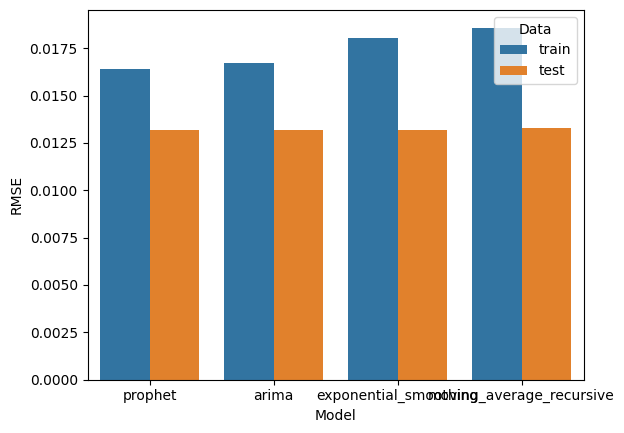

In [3]:
sns.barplot(x="Model", y="RMSE", hue="Data", data=rmse);

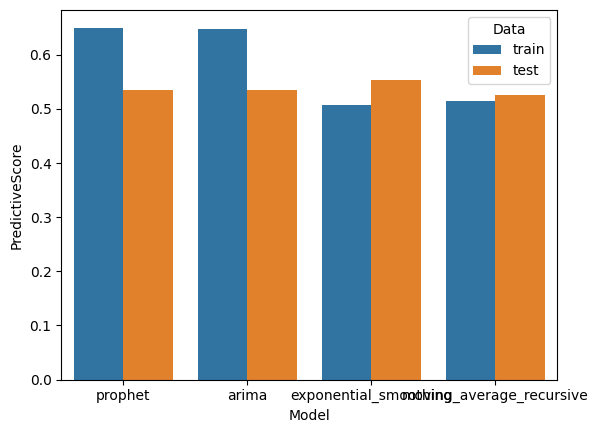

In [4]:
sns.barplot(x="Model", y="PredictiveScore", hue="Data", data=f1);

### Check Recommendation

In [5]:
rec = json.load(open("../results/recommendation.json", "r"))
long = rec["long"]
short = rec["short"]
print(long["Top Models"])
print(short["Top Models"])

['main_exponential_smoothing', 'main_prophet', 'main_arima']
['main_exponential_smoothing', 'main_prophet', 'main_arima']


In [6]:
long = pd.DataFrame({k: v for k, v in long.items() if k in ["risk", "reward"]}).transpose()
short = pd.DataFrame({k: v for k, v in short.items() if k in ["risk", "reward"]}).transpose()
pd.concat([
    pd.concat({"long": long}, names=["PositionType"]),
    pd.concat({"short": short}, names=["PositionType"])
])

Top Stock Predicted Return Model Agreement  \
PositionType                                                         
long         risk    AT00000VIE62          1.01513             100   
             reward  AT00000VIE62          1.01513             100   
short        risk    AT0000644505           0.9889             100   
             reward  AT0000644505           0.9889             100   

                    Market Trend MACD Crossover  \
PositionType                                      
long         risk        bullish              1   
             reward      bullish              1   
short        risk        neutral              0   
             reward      neutral              0   

                                        Market State  \
PositionType                                           
long         risk                    very overbought   
             reward                  very overbought   
short        risk    neither overbought nor oversold   
             reward  neither overbought nor oversold   

                    Fast Stochastic Oscillator Bollinger Band Breakout  
PositionType                                                            
long         risk                          100                       1  
             reward                        100                       1  
short        risk                           24                       0  
             reward                         24                       0